In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import pm4py
import scipy
import stormpy
import datetime
import numpy as np

In [75]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

In [ ]:
event_log = pm4py.read_xes('/home/vco/Datasets/BPI_Challenge_2013_incidents.xes.gz')
event_log = event_log.sort_values(['case:concept:name','time:timestamp'])
number_of_traces = event_log['case:concept:name'].nunique()
subset_el = event_log[['case:concept:name','concept:name','time:timestamp','org:resource','org:role']]
subset_el['org:role'] = subset_el['org:role'].fillna('nan_1').apply(lambda x: x.split('_')[0])
subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})

final_states = ['Completed']

In [5]:
subset_el = pm4py.convert_to_event_log(subset_el)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

In [6]:
subset_el = pm4py.convert_to_dataframe(subset_el)

In [7]:
times_dictionary = sim_util.extract_resource_times_with_future(subset_el)

In [8]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [9]:
data_mean_transition_role_time = {}
for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0
        for k3,v3 in v2.items():
            all_freq += v3
            times = times_dictionary[(k,k2,k3)]
            if len(times) > 1:
                expon_loc, expon_scale = scipy.stats.expon.fit(times)
                if expon_scale>0:
                    rate = 1/expon_scale
                    if k not in data_mean_transition_role_time:
                        data_mean_transition_role_time[k] = {}
                    if k2 not in data_mean_transition_role_time[k]:
                        data_mean_transition_role_time[k][k2] = {}
                    if k3 not in data_mean_transition_role_time[k][k2]:
                        data_mean_transition_role_time[k][k2][k3] = {'lambda': rate}

In [10]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [11]:
role_trials = {k:int(v) for k,v in role_resources.items()}

In [80]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

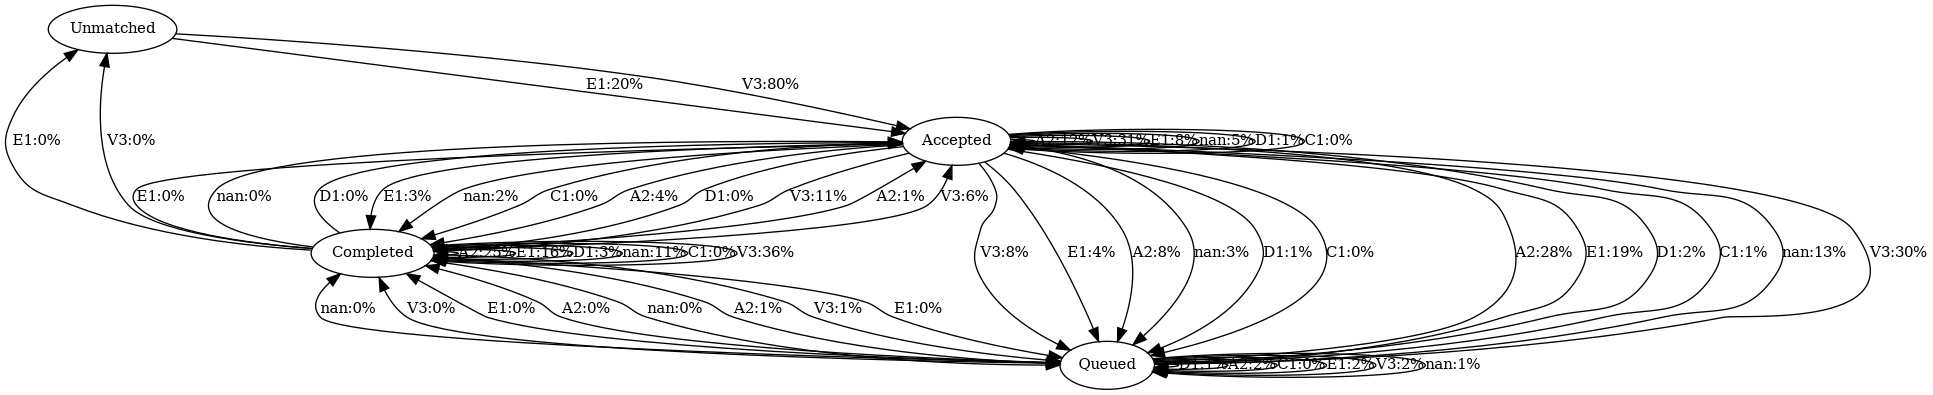

In [82]:
view_resource_markov_chain(data_transition_role_prob)

In [ ]:
semi_markov_json = mc_apply(subset_el)

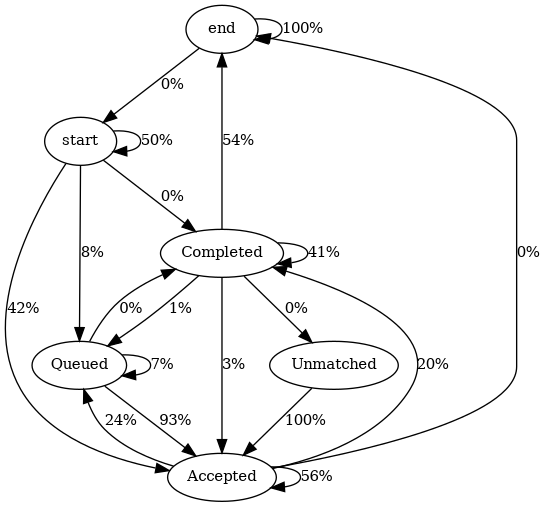

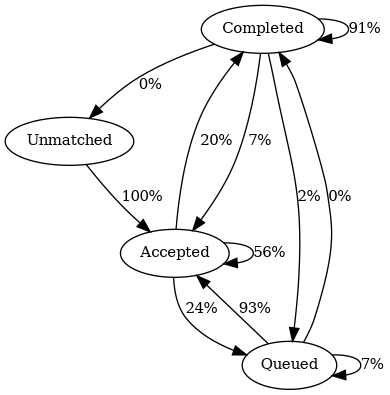

In [73]:
view_markov_chain(semi_markov_json)
view_non_resource_markov_chain(res)

In [20]:
from simulation.ctmc import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')
# print(probabilities)
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

formula_str = f'R=? [F {labels}]'
properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result//3600}")
if result<np.inf:
    print(f"Duration: {datetime.timedelta(seconds=result)}")

Hours: 17.0 WARN (Program.cpp:238): The input model is a CTMC, but uses probabilistic commands like they are used in PRISM. Consider rewriting the commands to use Markovian commands instead.

Duration: 17:36:07.766196


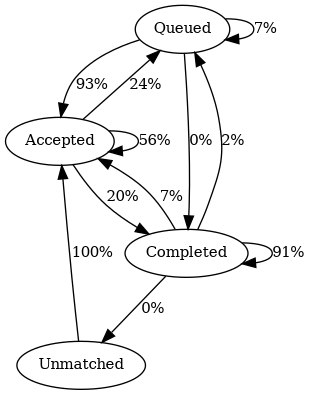

In [74]:
view_non_resource_markov_chain(probabilities)